import libraries

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd_
from IPython.display import display

Loud data

In [2]:
# פרמטרים מה-header
width = 50  # עמודות (x)
height = 50  # שורות (y)
bands = 91  # ערוצים (z)
dtype = np.int16  # data type = 2
interleave = 'bsq'

# קריאה מהקובץ
data = np.fromfile("../../Debbie's cube/bimodal.dat", dtype=dtype)

# reshape לפי BSQ (Band Sequential)
data = data.reshape((bands, height, width))

# העברה לצורה סטנדרטית (Height, Width, Channels)
data = np.transpose(data, (1, 2, 0))
x = torch.from_numpy(data).type(torch.float64)  # as tensor

print("Data shape:", data.shape)


Data shape: (50, 50, 91)


show data

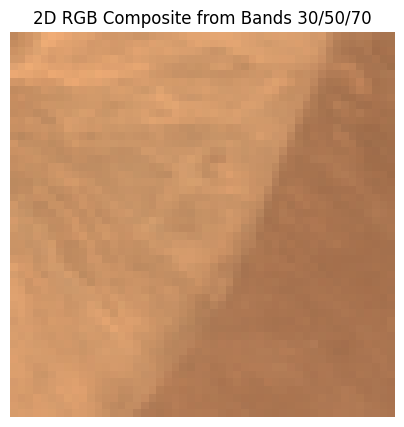

In [3]:
norm_data = (data - data.min()) / (data.max() - data.min())
rgb = norm_data[:, :, [30, 50, 70]]
plt.figure(figsize=(5, 5))
plt.imshow(rgb)
plt.title("2D RGB Composite from Bands 30/50/70")
plt.axis('off')
plt.show()


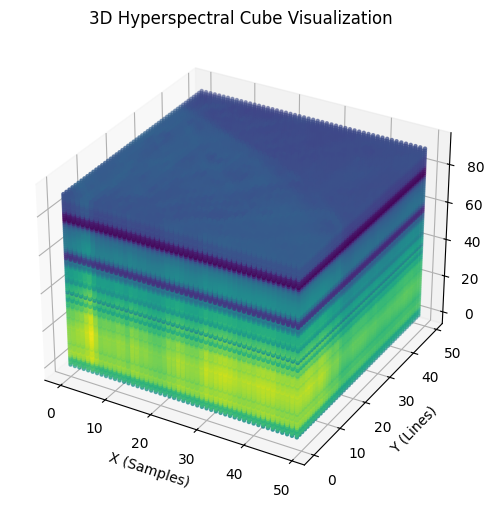

In [4]:
from mpl_toolkits.mplot3d import Axes3D

# נבחר תת-מדגם קטן כדי לא להעמיס (למשל 20x20x91)
x_, y, z = np.indices((50, 50, 91))
values = norm_data

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# הצגה כענן נקודות
ax.scatter(x_.flatten(), y.flatten(), z.flatten(),
           c=values.flatten(), cmap='viridis', marker='.')
ax.set_xlabel('X (Samples)')
ax.set_ylabel('Y (Lines)')
ax.set_zlabel('Bands')
ax.set_title('3D Hyperspectral Cube Visualization')

plt.show()


analysis

E8

In [5]:

print(f'data shape:{x.shape}')

data shape:torch.Size([50, 50, 91])


statistical : mean , error, cov

In [6]:
def m8(dataTensor, segment, x, y):
    neighbors = []
    dT = dataTensor.permute(2, 0, 1)[segment]
    if (x != dT.size(0) - 1):
        neighbors.append(dT[x + 1][y].item())
        if (y != dT.size(1) - 1):
            neighbors.append(dT[x + 1][y + 1].item())
        if (y != 0):
            neighbors.append(dT[x + 1][y - 1].item())
    if (x != 0):
        neighbors.append(dT[x - 1][y].item())
        if (y != dT.size(1) - 1):
            neighbors.append(dT[x - 1][y + 1].item())
        if (y != 0):
            neighbors.append(dT[x - 1][y - 1].item())
    if (y != dT.size(1) - 1):
        neighbors.append(dT[x][y + 1].item())
    if (y != 0):
        neighbors.append(dT[x][y - 1].item())
    return sum(neighbors) / len(neighbors)


In [7]:
m = torch.zeros(x.shape, dtype=torch.float64)

for segment in range(x.size(2)):
    for x_ in range(x.size(0)):
        for y in range(x.size(1)):
            m_ = m8(x, segment, x_, y)
            m[x_][y][segment] = m_

In [8]:
print((x - m).shape)

torch.Size([50, 50, 91])


In [9]:
error8Flat = (x - m).view(-1, bands)
cov = error8Flat.T @ error8Flat / (error8Flat.size(0) - 1)
print(cov.shape)

torch.Size([91, 91])


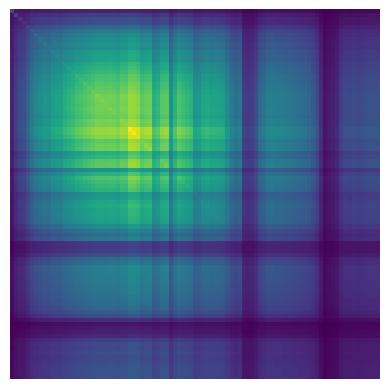

In [10]:
plt.imshow(cov)
plt.axis('off')
plt.show()

target

In [11]:
target = x[4][2]

tensor([3591., 4733., 4793., 4577.], dtype=torch.float64)


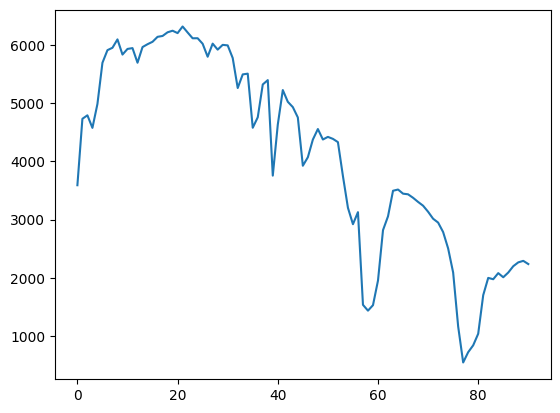

In [12]:
print(target[:4])
x_values = np.arange(len(target.numpy()))
# plt.plot(x_values, target.numpy())
# הקוד שלך נשאר:


plt.plot(target.numpy(), )  # שים לב: זוהי הפקודה שהוחלפה מ-plt.stem
plt.show()

In [13]:
# Target strength:
p = 0.01
x_tag = x + p * target
error8Flat_tag = (x_tag - m).view(-1, bands)

inverse cov

In [14]:
inv_cov = torch.inverse(cov)

without the target

In [15]:
error8Flat_tag.dtype

torch.float64

with the target

In [16]:



def plotAsTable(data):
    df = pd_.DataFrame(data)

    # --- פונקציות סטיילינג ---
    # פונקציה לצביעת הטקסט בעמודה NT באדום
    def color_nt(s):
        return ['color: red'] * len(s)

    # פונקציה לצביעת הטקסט בעמודה WT בכחול
    def color_wt(s):
        return ['color: blue'] * len(s)

    # --- יישום הסטיילינג והעיגול ---
    styled_df = (
        df.style
        # 🌟 NEW: עיגול כל המספרים בעמודות NT ו-WT לשתי ספרות אחרי הנקודה
        .format(
            {'NT': "{:.2f}",
             'WT': "{:.2f}"}
        )
        # צובע את כותרת העמודה NT באדום
        .set_properties(subset=pd_.IndexSlice[['NT']], **{'color': 'red'}, axis=1)
        # צובע את הנתונים בעמודה NT באדום
        .apply(color_nt, subset=['NT'])

        # צובע את כותרת העמודה WT בכחול
        .set_properties(subset=pd_.IndexSlice[['WT']], **{'color': 'blue'}, axis=1)
        # צובע את הנתונים בעמודה WT בכחול
        .apply(color_wt, subset=['WT'])

        # עיצוב כללי של הטבלה
        .set_table_styles([
            {'selector': 'th', 'props': [('border-bottom', '1px solid black')]},
            {'selector': 'td', 'props': [('border', '1px solid #ccc')]}
        ])
        .hide(axis='index')  # מסתיר את האינדקס המספרי
    )

    # הדפסת הטבלה המעוצבת ב-Jupyter Notebook
    return styled_df


In [17]:
error8_tag0 = error8Flat_tag.view(-1, height, bands)[:, :, 0]
error80 = error8Flat.view(-1, height, bands)[:, :, 0]
data_by_column = {
    "Pixel_location": ["(5, 5)", "(10, 10)", "(15, 15)", "(20, 20)"],
    "NT": [error80[4][4].tolist(), error80[9][9].tolist(), error80[14][14].tolist(), error80[19][19].tolist()],
    "WT": [error8_tag0[4][4].tolist(), error8_tag0[9][9].tolist(), error8_tag0[14][14].tolist(),
           error8_tag0[19][19].tolist()]
}

display(plotAsTable(data_by_column))



Pixel_location,NT,WT
"(5, 5)",-56.75,-20.84
"(10, 10)",-53.00,-17.09
"(15, 15)",21.88,57.78
"(20, 20)",-36.62,-0.72


In [18]:
nt = (target.view(1, 91) @ inv_cov @ error8Flat.view(-1, 91).T).view(x.shape[:2])
wt = (target.view(1, 91) @ inv_cov @ error8Flat_tag.view(-1, 91).T).view(x.shape[:2])

In [19]:
print('with target ')
print(f'wt : {wt[4][4].tolist():.2f},{wt[9][9].tolist():.2f},{wt[14][14].tolist():.2f},{wt[19][19].tolist():.2f}')

print(f'nt : {nt[4][4].tolist():.2f},{nt[9][9].tolist():.2f},{nt[14][14].tolist():.2f},{nt[19][19].tolist():.2f}')

with target 
wt : 629.48,363.23,427.17,385.33
nt : 166.13,-100.12,-36.18,-78.02


dencity  digram

In [20]:

data_by_column = {
    "Pixel_location": ["(5, 5)", "(10, 10)", "(15, 15)", "(20, 20)"],
    "NT": [nt[4][4].tolist(), nt[9][9].tolist(), nt[14][14].tolist(), nt[19][19].tolist()],
    "WT": [wt[4][4].tolist(), wt[9][9].tolist(), wt[14][14].tolist(), wt[19][19].tolist()]
}
display(plotAsTable(data_by_column))

Pixel_location,NT,WT
"(5, 5)",166.13,629.48
"(10, 10)",-100.12,363.23
"(15, 15)",-36.18,427.17
"(20, 20)",-78.02,385.33


In [21]:
range_ = (-1000, 1500)
bins = 100

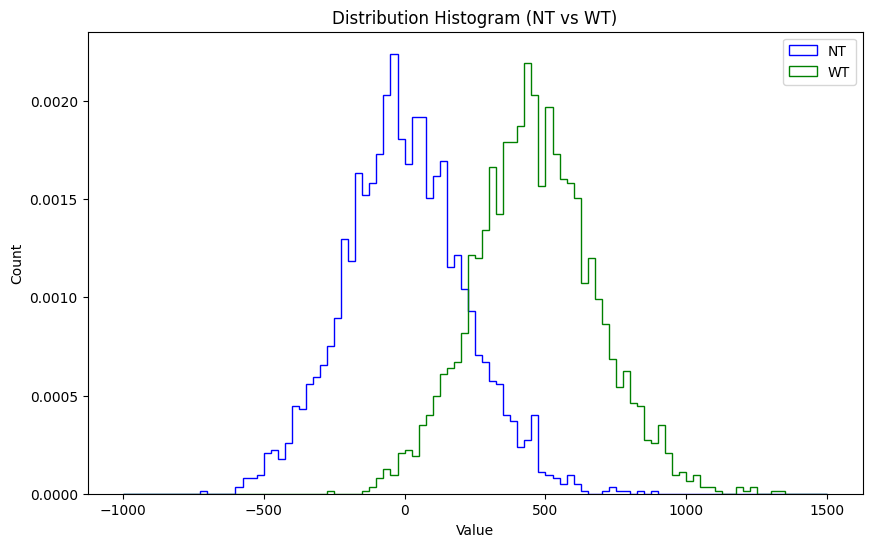

In [22]:


# ----------------------------------------------------------------------
# נתונים מדומים (יש להחליף בנתוני nt ו-wt האמיתיים שלך)

# ----------------------------------------------------------------------

plt.figure(figsize=(10, 6))

# היסטוגרמה 1 (NT - כחול): נצבע ונשים תווית NT ראשונה במקרא (כדי להתאים לתמונה)
# **שימו לב**: הסרנו את density=True
wtd, bins1, _ = plt.hist(
    nt.view(-1).numpy(),  # שימוש בנתוני NT
    bins=bins,
    range=range_,
    density=True,
    histtype='step',
    label='NT',  # הוספת התווית NT למקרא
    color='blue'  # צבע כחול
)

# היסטוגרמה 2 (WT - ירוק): נצבע ונשים תווית WT שנייה במקרא
# **שימו לב**: הסרנו את density=True
ntd, bins2, _ = plt.hist(
    wt.view(-1).numpy(),  # שימוש בנתוני WT
    bins=bins,
    range=range_,
    density=True,
    histtype='step',
    label='WT',  # הוספת התווית WT למקרא
    color='green'  # צבע ירוק
)

# הגדרות הגרף
plt.legend()
plt.xlabel("Value")
plt.ylabel("Count")  # שינינו ל-Count כי הסרנו density=True
plt.title("Distribution Histogram (NT vs WT)")
plt.show()

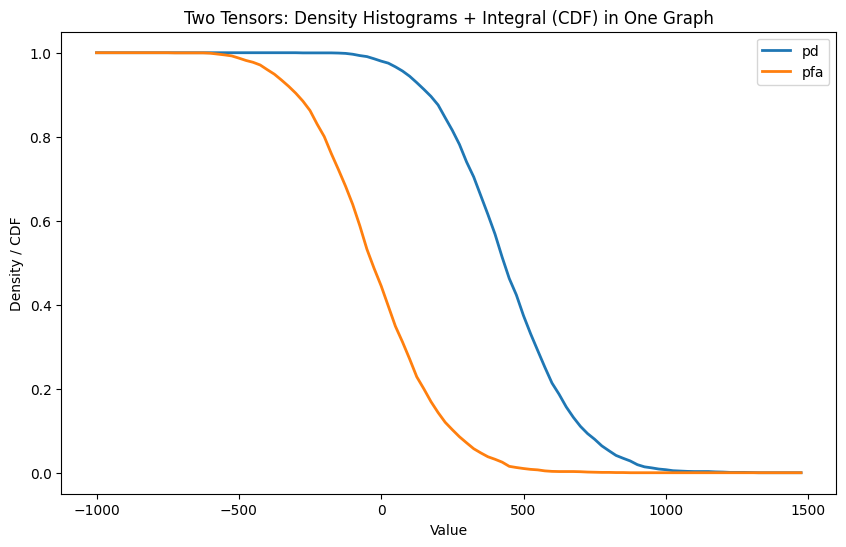

In [23]:
plt.figure(figsize=(10, 6))

# Histogram 1

pd = -np.cumsum(ntd * np.diff(bins1)) + 1
plt.plot(bins1[:-1], pd, linewidth=2, label='pd')

# Histogram 2
pfa = -np.cumsum(wtd * np.diff(bins2)) + 1
plt.plot(bins2[:-1], pfa, linewidth=2, label='pfa')

plt.xlabel("Value")
plt.ylabel("Density / CDF")
plt.title("Two Tensors: Density Histograms + Integral (CDF) in One Graph")
plt.legend()
plt.show()

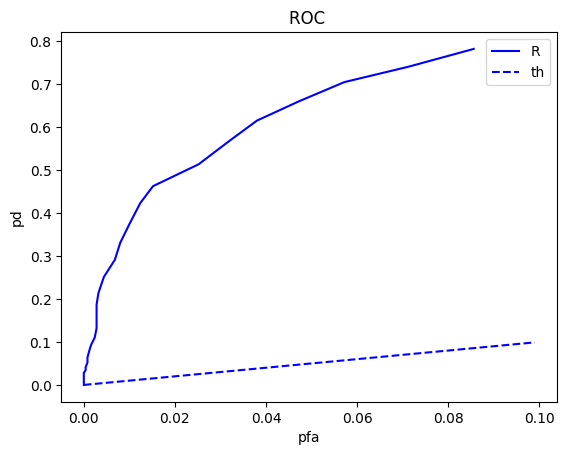

In [24]:
n_ = 0
for n in range(len(pfa)):
    if pfa[n] < 0.1:
        n_ = n
        break

plt.plot(pfa[n_:], pd[n_:], label="R", color='blue')
plt.plot(np.arange(0, 0.1, 0.001), np.arange(0, 0.1, 0.001), label="th", color='blue', linestyle='--')

plt.xlabel("pfa")
plt.ylabel("pd")
plt.title("ROC ")
plt.legend()
plt.show()


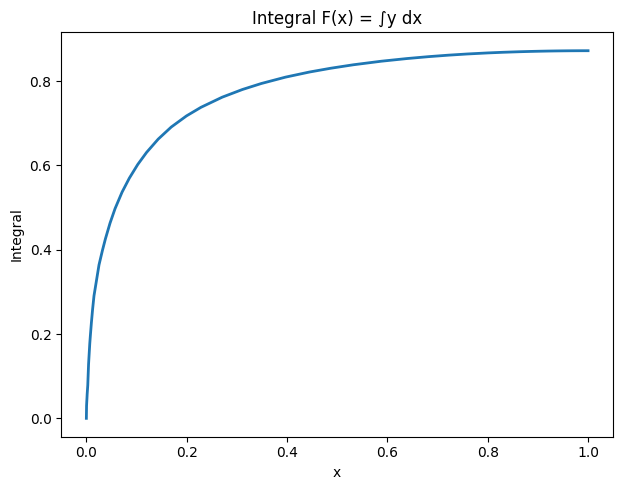

In [25]:



# x and y are already numpy arrays of shape (1000,)
# but ensure they are 1D
pfa_ = pfa.flatten()
pd_n = pd.flatten() - pfa_

# --- Sort by x ---
sort_idx = np.argsort(pfa_)
x_sorted = pfa_[sort_idx]
y_sorted = pd_n[sort_idx]

# --- Cumulative integral using trapezoidal rule ---
a_th = np.zeros_like(y_sorted)
a_th[1:] = np.cumsum((y_sorted[:-1] + y_sorted[1:]) * np.diff(x_sorted)) / (
        2 * (x_sorted[1:] - x_sorted[1:] * x_sorted[1:] / 2))

# --- Plot both graphs ---
plt.figure(figsize=(12, 5))

# Integral curve
plt.subplot(1, 2, 2)
plt.plot(x_sorted, a_th, linewidth=2)
plt.title("Integral F(x) = ∫y dx")
plt.xlabel("x")
plt.ylabel("Integral")

plt.tight_layout()
plt.show()



In [26]:
def sROC(x):
    for i, n in enumerate(x_sorted):
        if n > x:
            return (a_th[i].tolist())
    return (1.0)


In [27]:
type(sROC(0.1))

float

In [28]:
print(f'0.001-> {sROC(0.001):.4f}' )
print(f'0.01-> {sROC(0.01):.4f}' )
print(f'0.1-> {sROC(0.1):.4f}' )


0.001-> 0.0479
0.01-> 0.2583
0.1-> 0.6023
